# Introduction to Data Analytics Coursework -- Text Analytics Data Loader

For this coursework, we recommend that you use your virtual environment that you created for the labs. Alternatively, create a fresh environment following the instructions in the [README.md in the intro-labs-public Github repository](https://github.com/uob-TextAnalytics/intro-labs-public). 

In [84]:
%load_ext autoreload
%autoreload 2

# Use HuggingFace's datasets library to access the financial_phrasebank dataset
from datasets import load_dataset

import numpy as np
import seaborn as sns
import pandas as pd
from nltk import word_tokenize
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import re
from bs4 import BeautifulSoup
import unicodedata
from spacy.lang.en.stop_words import STOP_WORDS
from nltk.corpus import stopwords

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Financial Question Answering Task 1 -- Sentiment Analysis (FiQA SA)

The FiQA SA dataset contains two sets of different instances: news headlines and social media posts. The data is available from the website of the FiQA competition: https://sites.google.com/view/fiqa/home . 

Each instance has a continuous sentiment score. Our task is to classify the posts into positive (2), negative (0) or neutral (1). First, load both the headlines and posts, along with their sentiment scores, then bin the scores into positive, negative and neutral:

In [4]:
train_files = [
    'data_cache/FiQA_ABSA_task1/task1_headline_ABSA_train.json',
    'data_cache/FiQA_ABSA_task1/task1_post_ABSA_train.json'
]

In [5]:
import json

def load_fiqa_sa_from_json(json_files):
    train_text = []
    train_labels = []

    for file in json_files:
        with open(file, 'r', encoding="utf-8") as handle:
            dataf = json.load(handle)

        dataf_text = [dataf[k]["sentence"] for k in dataf.keys()]
        # print(len(dataf_text))
        train_text.extend(dataf_text)

        dataf_labels = [float(dataf[k]["info"][0]["sentiment_score"]) for k in dataf.keys()]
        # print(len(dataf_labels))
        train_labels.extend(dataf_labels)

    train_text = np.array(train_text)
    train_labels = np.array(train_labels)
    
    return train_text, train_labels


def threshold_scores(scores):
    """
    Convert sentiment scores to discrete labels.
    0 = negative.
    1 = neutral.
    2 = positive.
    """
    labels = []
    for score in scores:
        if score < -0.2:
            labels.append(0)
        elif score > 0.2:
            labels.append(2)
        else:
            labels.append(1)
            
    return np.array(labels)


all_text, all_labels = load_fiqa_sa_from_json(train_files)
    
print(f'Number of instances: {len(all_text)}')
print(f'Number of labels: {len(all_labels)}')

all_labels = threshold_scores(all_labels)
print(f'Number of negative labels: {np.sum(all_labels==0)}')
print(f'Number of neutral labels: {np.sum(all_labels==1)}')
print(f'Number of positive labels: {np.sum(all_labels==2)}')

Number of instances: 1111
Number of labels: 1111
Number of negative labels: 310
Number of neutral labels: 195
Number of positive labels: 606


In [37]:
df = pd.DataFrame({'tweet':all_text, 'label':all_labels})
df.head()

,tweet,label
0,Royal Mail chairman Donald Brydon set to step ...,0
1,Stakes High for AstraZeneca Heart Drug Facing ...,0
2,UPDATE 1-Dairy Crest loses a third of Morrison...,1
3,Insight hires Aviva's David Hillier for multi-...,1
4,Primark racks up a happy Christmas after stron...,2


### WordCloud

In [38]:
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image

negative_sent = df['tweet'][df['label'] == 0]
neutral_sent = df['tweet'][df['label'] == 1]
positive_sent = df['tweet'][df['label'] == 2]

def list_tokenizer(label):
    labels = " ".join(label)
    labels = word_tokenize(labels)
    return str(labels)

def word_cloud(label, number):
    wc = WordCloud(background_color='black', max_font_size=48, max_words=100)
    wc.generate(label)
    plt.figure(figsize=(10, 8))
    plt.imshow(wc, interpolation='bilinear')
    plt.title(f'WordCloud for label: {number}')
    plt.axis('off')


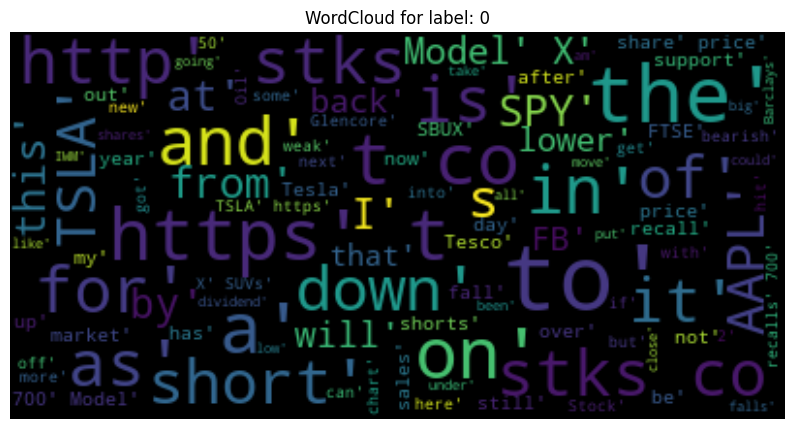

In [39]:
word_cloud(list_tokenizer(negative_sent), 0)

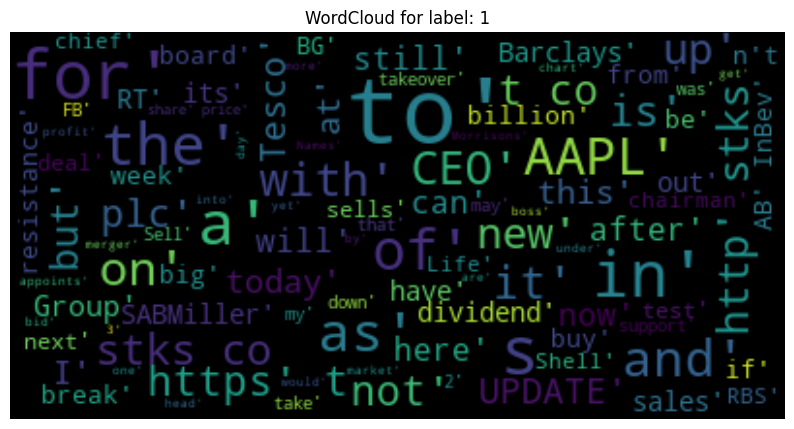

In [40]:
word_cloud(list_tokenizer(neutral_sent), 1)

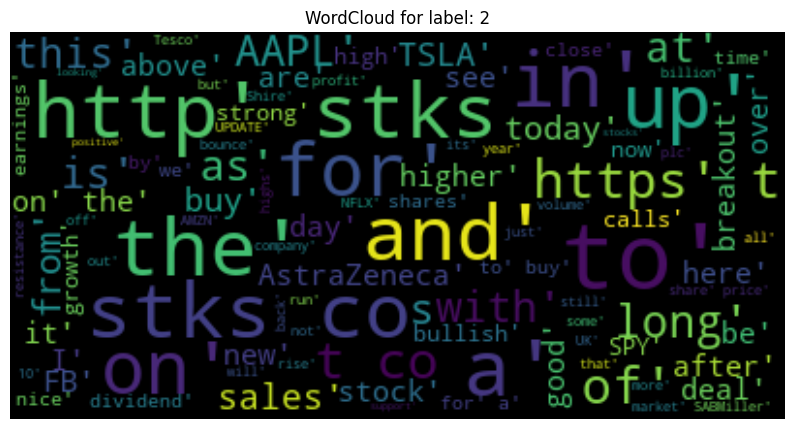

In [41]:
word_cloud(list_tokenizer(positive_sent), 2)

### Model without pre-processing the data

Let's create a test split, which we can hold out until we have tuned our method(s).

We may also need a _validation_ set (also called 'development' set or 'devset'), which can be used to compute performance of your model when tuning hyperparameters,  optimising combinations of features, or looking at the errors your model makes before improving it. This allows you to hold out the test set (i.e., not to look at it at all when developing your method) to give a fair evaluation of the model and how well it generalises to new examples. This avoids tuning the model to specific examples in the test set. An alternative approach to validation set does not use a single fixed validation set, but instead uses [cross validation](https://scikit-learn.org/stable/modules/cross_validation.html). 

In [6]:
from sklearn.model_selection import train_test_split

# Split test data from training data
train_documents, test_documents, train_labels, test_labels = train_test_split(
    all_text, 
    all_labels, 
    test_size=0.2, 
    stratify=all_labels  # make sure the same proportion of labels is in the test set and training set
)

# Split validation data from training data
train_documents, val_documents, train_labels, val_labels = train_test_split(
    train_documents, 
    train_labels, 
    test_size=0.15, 
    stratify=train_labels  # make sure the same proportion of labels is in the test set and training set
)

print(f'Number of training instances = {len(train_documents)}')
print(f'Number of validation instances = {len(val_documents)}')
print(f'Number of test instances = {len(test_documents)}')


Number of training instances = 754
Number of validation instances = 134
Number of test instances = 223


In [7]:
print(f'What does one instance look like from the training set? \n\n{train_documents[234]}')
print(f'...and here is its corresponding label \n\n{train_labels[234]}')

What does one instance look like from the training set? 

My $DWA play up 6% today. I'm still skeptical. Will take profits. Not a time cheer
...and here is its corresponding label 

1


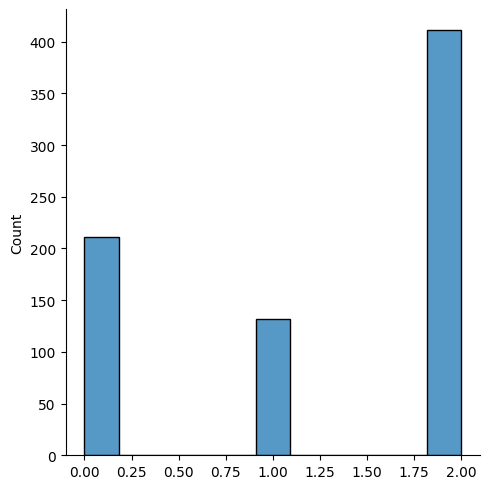

In [21]:
sns.displot(train_labels)

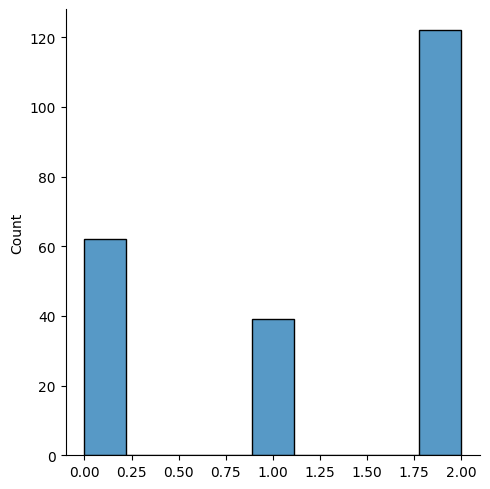

In [20]:
sns.displot(test_labels)

In [26]:
df_train = pd.DataFrame({'tweet':train_documents, 'label':train_labels})
df_train.head()

,tweet,label
0,$GOOG Testing the 200 day after some consolida...,2
1,Long $X 24.62,2
2,@BrooklynBandit: $SIMO Basing nice. A close ov...,2
3,Watch these bancos.they're holding up relative...,2
4,what is up with $HK..... from Jan to now it's ...,0


In [48]:
vectorizer = CountVectorizer()
Xtrain_bow = vectorizer.fit_transform(train_documents).toarray()
Xval_bow = vectorizer.transform(val_documents).toarray()

In [49]:
clf_bow = MultinomialNB().fit(Xtrain_bow, train_labels)
pred_bow = clf_bow.predict(Xval_bow)

In [52]:
print(f"Confusion Matrix:\n {confusion_matrix(pred_bow, val_labels)}")
print(f"Accuracy:\n {accuracy_score(pred_bow, val_labels)}")
print(f"Classification Report:\n {classification_report(pred_bow, val_labels)}")

Confusion Matrix:
 [[23  4  3]
 [ 0  3  4]
 [14 17 66]]
Accuracy:
 0.6865671641791045
Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.77      0.69        30
           1       0.12      0.43      0.19         7
           2       0.90      0.68      0.78        97

    accuracy                           0.69       134
   macro avg       0.55      0.63      0.55       134
weighted avg       0.80      0.69      0.73       134



### Pre-porcessing

In [69]:
# Lowercase everything
all_text_processed = np.char.lower(all_text)
all_text_processed[:5]

array(['royal mail chairman donald brydon set to step down',
       'stakes high for astrazeneca heart drug facing tough competition',
       'update 1-dairy crest loses a third of morrisons milk contract',
       "insight hires aviva's david hillier for multi-asset team",
       'primark racks up a happy christmas after strong sales'],
      dtype='<U142')

In [70]:
# Regex to remove emails from tweets
email_pattern = r'/\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b'
all_text_processed = np.vectorize(lambda x: re.sub(email_pattern, '', x))(all_text_processed)

In [71]:
# Getting rid of URLs from the tweets
url_pattern = r'(https?:\/\/)?([\da-z\.-]+)\.([a-z\.]{2,6})([\/\w \.-]*)*\/?'
all_text_processed = np.vectorize(lambda x: re.sub(url_pattern, '', x))(all_text_processed)

In [72]:
# Get rid of re-tweets
all_text_processed = np.vectorize(lambda x: re.sub('RT', '', x))(all_text_processed)

In [73]:
# Getting rid of punctuations
all_text_processed = np.vectorize(lambda x: re.sub('[^a-zA-Z0-9-]+', '', x))(all_text_processed)

In [75]:
# Removing multiple whitespaces if exist
all_text_processed = np.vectorize(lambda x: " ".join(x.split()))(all_text_processed)

In [78]:
# Removing HTML tags
all_text_processed = np.vectorize(lambda x: BeautifulSoup(x, 'lxml').get_text())(all_text_processed)

In [81]:
# Normalize accented chars (Déjà vu -> Deja vu)
def norm_accented_chars(x):
    x = unicodedata.normalize('NFKD', x).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return x

all_text_processed = np.vectorize(norm_accented_chars)(all_text_processed)

### Model Building
#### Splitting the data into train, test and validation sets

In [90]:
# Split test data from training data
p_train_documents, p_test_documents, p_train_labels, p_test_labels = train_test_split(
    all_text, 
    all_labels, 
    test_size=0.2, 
    stratify=all_labels  # make sure the same proportion of labels is in the test set and training set
)

# Split validation data from training data
p_train_documents, p_val_documents, p_train_labels, p_val_labels = train_test_split(
    p_train_documents, 
    p_train_labels, 
    test_size=0.15, 
    stratify=p_train_labels  # make sure the same proportion of labels is in the test set and training set
)

In [91]:
p_vectorizer = CountVectorizer()
p_Xtrain_bow = p_vectorizer.fit_transform(p_train_documents).toarray()
p_Xval_bow = p_vectorizer.transform(p_val_documents).toarray()

#### Building a model

In [92]:
p_clf_bow = MultinomialNB().fit(p_Xtrain_bow, p_train_labels)
p_pred_bow = p_clf_bow.predict(p_Xval_bow)

In [93]:
print(f"Confusion Matrix:\n {confusion_matrix(p_pred_bow, p_val_labels)}")
print(f"Accuracy:\n {accuracy_score(p_pred_bow, p_val_labels)}")
print(f"Classification Report:\n {classification_report(p_pred_bow, p_val_labels)}")

Confusion Matrix:
 [[11  3  4]
 [ 1  3  2]
 [25 18 67]]
Accuracy:
 0.6044776119402985
Classification Report:
               precision    recall  f1-score   support

           0       0.30      0.61      0.40        18
           1       0.12      0.50      0.20         6
           2       0.92      0.61      0.73       110

    accuracy                           0.60       134
   macro avg       0.45      0.57      0.44       134
weighted avg       0.80      0.60      0.66       134



# BIONLP 2004

This dataset contains abstracts from MEDLINE, a database containing journal articles from fields including medicine and pharmacy. 
The data was collected by searching for the terms ‘human’, ‘blood cells’ and ‘transcription factors’, and then annotated with five entity types: DNA, protein, cell type, cell line, RNA. 

More information in the paper: https://aclanthology.org/W04-1213.pdf

The data can be downloaded from HuggingFace: https://huggingface.co/datasets/tner/bionlp2004

In [8]:
dataset = load_dataset(
    "tner/bionlp2004", 
    cache_dir='./data_cache'
)

print(f'The dataset is a dictionary with {len(dataset)} splits: \n\n{dataset}')

Using custom data configuration bionlp2004-299cca8815996877


Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Dataset json downloaded and prepared to /mnt/d/Data Science MSc/Intro to DA/Coursework/data_cache/json/bionlp2004-299cca8815996877/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

The dataset is a dictionary with 3 splits: 

DatasetDict({
    train: Dataset({
        features: ['tags', 'tokens'],
        num_rows: 16619
    })
    test: Dataset({
        features: ['tags', 'tokens'],
        num_rows: 3856
    })
    validation: Dataset({
        features: ['tags', 'tokens'],
        num_rows: 1927
    })
})


The dataset is already split into train, validation and test. It may be useful to reformat the DatasetDict object into lists of sentences and tags:

In [9]:
train_sentences_ner = [item['tokens'] for item in dataset['train']]
train_labels_ner = [[str(tag) for tag in item['tags']] for item in dataset['train']]

val_sentences_ner = [item['tokens'] for item in dataset['validation']]
val_labels_ner = [[str(tag) for tag in item['tags']] for item in dataset['validation']]

test_sentences_ner = [item['tokens'] for item in dataset['test']]
test_labels_ner = [[str(tag) for tag in item['tags']] for item in dataset['test']]

In [10]:
print(f'Number of training sentences = {len(train_sentences_ner)}')
print(f'Number of validation sentences = {len(val_sentences_ner)}')
print(f'Number of test sentences = {len(test_sentences_ner)}')

Number of training sentences = 16619
Number of validation sentences = 1927
Number of test sentences = 3856


In [11]:
print(f'What does one instance look like from the training set? \n\n{train_sentences_ner[234]}')
print(f'...and here is its corresponding label \n\n{train_labels_ner[234]}')

What does one instance look like from the training set? 

['Hence', ',', 'PPAR', 'can', 'positively', 'or', 'negatively', 'influence', 'TH', 'action', 'depending', 'on', 'TRE', 'structure', 'and', 'THR', 'isotype', '.']
...and here is its corresponding label 

['0', '0', '3', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '3', '4', '0']


In [12]:
print(f'Number of unique labels: {np.unique(np.concatenate(train_labels_ner))}')

Number of unique labels: ['0' '1' '10' '2' '3' '4' '5' '6' '7' '8' '9']


These are the tags used to annotate the entities:

In [13]:
# mapping from labels to the tags

id2label = {
    "O": 0,
    "B-DNA": 1,
    "I-DNA": 2,
    "B-protein": 3,
    "I-protein": 4,
    "B-cell_type": 5,
    "I-cell_type": 6,
    "B-cell_line": 7,
    "I-cell_line": 8,
    "B-RNA": 9,
    "I-RNA": 10
}

label2id = {v:k for k, v in id2label.items()}
print(label2id)

{0: 'O', 1: 'B-DNA', 2: 'I-DNA', 3: 'B-protein', 4: 'I-protein', 5: 'B-cell_type', 6: 'I-cell_type', 7: 'B-cell_line', 8: 'I-cell_line', 9: 'B-RNA', 10: 'I-RNA'}
